In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
traindata = pd.read_csv("train.csv")
testdata = pd.read_csv("test.csv")
traindata.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Obviously there is a need to drop "PassengerId" and "Name" columns because they do not affect "Survived" column

In [3]:
traindata.drop(["PassengerId", "Name"], axis = 1, inplace = True)
traindata.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,female,35.0,1,0,113803,53.1000,C123,S
4,0,3,male,35.0,0,0,373450,8.0500,NaN,S


Due to the ratio between count of Cabin NaNs and count of rows may be it is optimal to drop Cabin to improve model quality. But we will try that later

In [4]:
print(traindata.shape)
traindata.isnull().sum()


(891, 10)


Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

The volume of unique values of ticket column is too huge, perhaps it does not contain core information:

In [5]:
traindata = traindata.drop("Ticket", axis = 1)

Applying one-hot encoding for columns with string values, nans and int categorical marks:

In [6]:
columns_to_encode = ["Sex", "Cabin", "Embarked"]

In [7]:
trainencoded = pd.concat([pd.get_dummies(traindata[columns_to_encode], dummy_na = True), traindata.drop(columns_to_encode, axis =1)], axis = 1)

In [8]:
trainencoded

,Sex_female,Sex_male,Sex_nan,Cabin_A10,Cabin_A14,Cabin_A16,Cabin_A19,Cabin_A20,Cabin_A23,Cabin_A24,...,Embarked_C,Embarked_Q,Embarked_S,Embarked_nan,Survived,Pclass,Age,SibSp,Parch,Fare
0,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,3,22.0,1,0,7.2500
1,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,1,38.0,1,0,71.2833
2,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,3,26.0,0,0,7.9250
3,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,1,35.0,1,0,53.1000
4,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,3,35.0,0,0,8.0500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,2,27.0,0,0,13.0000
887,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,1,19.0,0,0,30.0000
888,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,3,NaN,1,2,23.4500
889,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,1,1,26.0,0,0,30.0000


No outliers detected:

In [9]:
traindata.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Age column contains NaN values. Replacing with mean age:

In [10]:
trainencoded["Age"].fillna(trainencoded["Age"].mean(), inplace = True)

<h4> Concerning correlations between values:</h4>

SibSp has high correlation with Parch and Fare level correlates positively with probabilyty to survive:

<AxesSubplot:>

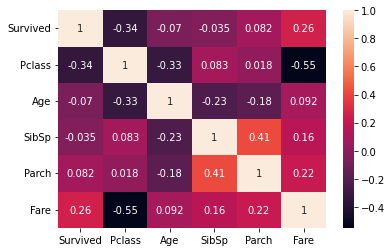

In [11]:
corr = trainencoded[trainencoded.columns[-6:161]].corr()
sns.heatmap(corr, annot = True)

T-SNE reveals some pattern using for these columns: Survived,	Pclass,	 Age,	SibSp,	Parch,	Fare

In [12]:
from sklearn.manifold import TSNE
compressed = TSNE(n_components=2, learning_rate=10, min_grad_norm = 0.0005,
init='random', n_jobs = 4).fit_transform(trainencoded[trainencoded.columns[-6:161]])
tsne_ds = pd.concat([traindata["Survived"], pd.DataFrame(compressed)], axis = 1)

<AxesSubplot:xlabel='0', ylabel='1'>

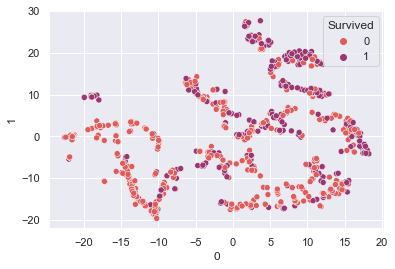

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
palette = sns.color_palette("flare",2)
sns.set_theme(palette = palette)
f, ax = plt.subplots()
sns.scatterplot(data = tsne_ds, x = 0, y = 1, hue = "Survived")

Trying the same but with all columns. Some pattern still exist, it means that the SVM has potential for applying models

<AxesSubplot:xlabel='0', ylabel='1'>

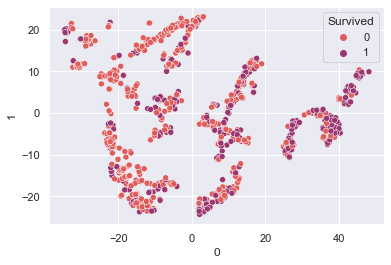

In [14]:
compressed_all = TSNE(n_components=2, learning_rate=10, min_grad_norm = 0.00005,
init='random', n_jobs = 4).fit_transform(trainencoded)
tsne_ds_all = pd.concat([traindata["Survived"], pd.DataFrame(compressed_all)], axis = 1)
sns.scatterplot(data = tsne_ds_all, x = 0, y = 1, hue = "Survived")

Applying Random Forest Classifier:

Create split for test data and train data:

In [15]:
from sklearn.model_selection import train_test_split
xtrain = trainencoded.drop(["Survived"], axis = 1)
ytrain = trainencoded["Survived"]
X_train, X_test, y_train, y_test = train_test_split(xtrain, ytrain, test_size =  0.2, random_state = 42)

In [17]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier


preds = []
for ftr in range(10, 80, 10):
    for est in range(3, 50, 5):
        for splt in range(5, 100, 5):
            for dp in range(2, 40, 5):
                model = RandomForestClassifier(max_features = ftr/100, n_estimators = 15, min_samples_split = 20, max_depth = 10)
                model.fit(X_train, y_train)
                scores = cross_val_score(model, X_train, y_train, cv=4)
                preds.append({"score":np.median(scores), "max_features":ftr/100, "n_estimators":est, "min_samples_split":splt, "depth":dp})
p = sorted(preds, key = lambda item: item["score"])

The best parameters for Random Forest

In [18]:
print(p[-1])

{'score': 0.8370786516853932, 'max_features': 0.4, 'n_estimators': 13, 'min_samples_split': 85, 'depth': 37}


This is how the Random Forest progress looks like. There were lots of of parameters that give the same score:

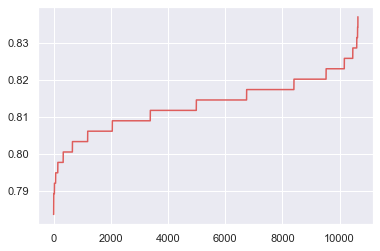

In [19]:
xlin = [i for i in range(1, 10641)]
ylin = [p[i]["score"] for i in range(len(p))]
plt.plot(xlin, ylin)

Cross Validation with K-Fold method:
P.S. The predictions are based on the X-axis, and the true values situated on the Y-axis on the heatmap.

              precision    recall  f1-score   support

           0       0.78      0.86      0.82       105
           1       0.77      0.66      0.71        74

    accuracy                           0.78       179
   macro avg       0.77      0.76      0.76       179
weighted avg       0.78      0.78      0.77       179



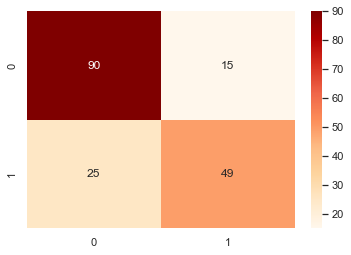

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import seaborn as sns
model = RandomForestClassifier(max_features = 0.5, n_estimators = 13, min_samples_split = 30, max_depth = 37)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)
#display = ConfusionMatrixDisplay(conf_matrix)
#display.plot()
sns.heatmap(conf_matrix, annot=True,cmap="OrRd")
print(classification_report(y_test, y_pred))


Cross-validation with 4 sample-packs. The score varies significantly depending on a particular sample-pack

In [21]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, X_train, y_train, cv=4)
print(f'Minimum score: {min(scores)}, Maximum score: {max(scores)}')
print(*scores)
print(f"The median score is: {np.median(scores)}")

Minimum score: 0.8033707865168539, Maximum score: 0.8764044943820225
0.8089887640449438 0.8764044943820225 0.8033707865168539 0.8370786516853933
The median score is: 0.8230337078651686


Estimation of feature importances according to Random Forest model:

<AxesSubplot:>

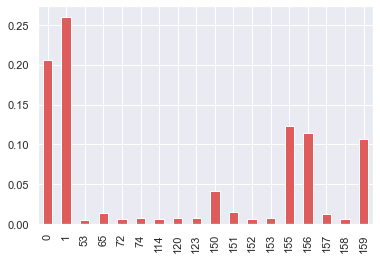

In [27]:
imp = model.feature_importances_
forest_importances = pd.Series(imp)
best_columns = xtrain.columns[forest_importances[forest_importances>0.150].index]
forest_importances[forest_importances>0.005].plot.bar()

The most important features:

<AxesSubplot:>

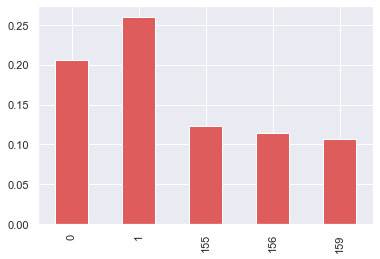

In [28]:
forest_importances[forest_importances>0.100].plot.bar()

Sex gives the most powerful impact:

In [51]:
print(*best_columns.values)

Sex_female Sex_male


Significant, but not the best columns are Pclass, Age and Fare (last 3 columns on the bar chart)

In [50]:
filter_ = (forest_importances>0.10) & (forest_importances<0.15)
significant_columns = xtrain.columns[forest_importances[filter_].index]
print(*significant_columns.values)

Pclass Age Fare


Applying SVC model using cross-validation:

In [70]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
X_train, X_test, y_train, y_test = train_test_split(xtrain, ytrain, test_size =  0.3, random_state = 42)


scores = []
for gamma in range(100, 500, 50):
    for toler in range(500, 5000, 250):
        clf = make_pipeline(StandardScaler(), SVC(cache_size = 2048, random_state = 42, gamma = 1/gamma, tol = 1/toler))
        score = np.median(cross_val_score(clf, X_train, y_train, cv = 4, n_jobs = 6))
        scores.append({"score":score, "gamma":1/gamma, "tol": 1/toler})


By changing gamma and tol parameters score fluctuates insignificantly from 0.77 to 0.78

In [77]:
x = sorted(scores, key = lambda item: item["score"], reverse = True)
print(f"The best result and parameters: {x[0]}")
print(f"The worst result: {x[-1]}")

The best result and parameters: {'score': 0.782051282051282, 'gamma': 0.01, 'tol': 0.002}
The worst result: {'score': 0.7756410256410255, 'gamma': 0.002857142857142857, 'tol': 0.0002105263157894737}


Applying K-neighbours Classifier and finding best parameters using cross validation in cicle:

In [93]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
predictions = []
for i in range(2, 500):
    neigh = KNeighborsClassifier(n_neighbors=i)
    score = np.median(cross_val_score(neigh, X_train, y_train, cv = 4, n_jobs = 6))
    predictions.append({"score":score, "n_neighbors":i})
x = sorted(predictions, key = lambda item: item["score"], reverse = True)
x[0]

{'score': 0.7202646815550041, 'n_neighbors': 5}

Score depending on amount of neighbors graph:

In [94]:
predictions_scores = [item["score"] for item in predictions]
nbrs = list(range(2, 500))

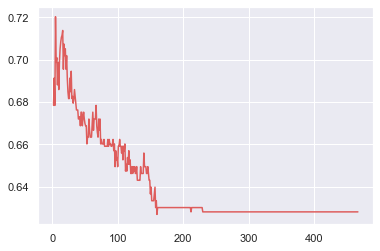

In [95]:
import matplotlib.pyplot as plt
plt.plot(nbrs, predictions_scores)